In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from Resources.Model import Model_v25
from Resources.Game import *
from Resources.TS_ModelGuided import *
from Resources.TS_ModelGuided_MCRollout import *
from Resources.TS_ModelGuided_SensAnalysis import *

from test_games import test_games


In [2]:
# # Tree Search guided by value function and sensitivity analysis of the value function

# import time
# import numpy as np
# import random
# import torch
# import torch.autograd.functional as Func
# import sys, os

# project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# sys.path.append(project_root)

# from Resources.Game import *
# from Resources.RollingMedian import RollingMedian

# def sensitivity_extraction_1(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 1: 2-norm of gradient
#     '''
#     return torch.norm(grad, p=2).item()

# def sensitivity_extraction_2(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 2: unweighted sum of gradient
#     '''
#     return torch.sum(grad).item()

# def sensitivity_extraction_3(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 3: activation function -> sum of gradient
#     '''
#     return torch.sum(torch.tanh(grad)).item()

# def sensitivity_extraction_4(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 4: pooling over each piece type -> act. function -> then sum
#     '''
#     return torch.sum(torch.tanh(torch.sum(grad, dim=(1, 2)))).item()

# def sensitivity_extraction_5(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 5: learned extraction function (e.g. NN)

#     possible future implementation
#     '''
#     return None

# def SensAnalysis_TS(game, model, root=None, tmax=60, batches=10, prints=False, factors=None, factor_wins=1, 
#                    factor_mat=0, factor_value_sum=0.5, factor_value_indi=0.5, 
#                    factor_grad_sum=0.1, factor_grad_indi=0.1,
#                    factor_explore=1e-3,
#                    sensitivity_extraction = sensitivity_extraction_1):
#     '''
#     Tree Search Guided by model and its sensitivity via model gradient
#     '''

#     # Create the root node if not passed
#     if root is None:
#         if factors is None:
#             root = SensAnalysis_Node(None, None, game, [factor_wins, factor_mat, 
#                                 factor_value_sum, factor_value_indi, 
#                                 factor_grad_sum, factor_grad_indi,
#                                 factor_explore]) 
#         if factors is not None:
#             root = SensAnalysis_Node(None, None, game, factors) 

#     root.game.FlipBoard()
#     board_batch = [board_to_tensor(root.game.pieces)]
#     nodes = [root]
#     root.game.FlipBoard()

#     for _ in range(batches):

#         t0 = time.time()
#         while time.time() - t0 < float(tmax) / float(batches):

#             node = root

#             # Selection
#             while not node.is_leaf() and node.is_fully_expanded():
#                 node = node.select_child()

#             # Expansion
#             if not node.is_fully_expanded():
#                 node, board_batch = node.expand(board_batch)

#             if node.game.is_over():
#                 winner = node.game.get_winner()
#             else:
#                 winner = None

#             # backpropagation of winner, matdiff
#             for_side = node.player

#             node.backpropagate(winner, node.matdiff, for_side, prints)
            
#             nodes.append(node)
#             # board_batch.append(board_to_tensor(node.game.pieces))

#         batch_size = len(board_batch)

#         if batch_size == 0:
#             continue

#         # get model values
#         tens_board_batch = torch.stack(board_batch)
#         tens_board_batch.requires_grad = True
#         values = model(tens_board_batch).detach().numpy()

#         # get each gradient w.r.t. input by vectorising input and using jacobian functionality
#         vectorized_input = tens_board_batch.view(batch_size, -1)
#         jacobian_matrix = Func.jacobian(lambda x: model(x.view(-1, 12, 8, 8)).sum(), vectorized_input)
#         gradients = jacobian_matrix.view(batch_size, 12, 8, 8)

#         for node, value, grad in zip(nodes, values, gradients):

#             for_side = node.player
#             grad_ext = sensitivity_extraction(grad)

#             # node.backpropagate_value(value, for_side)
#             node.backpropagate_value_grad(value, grad_ext, for_side)
#             node.value = value
#             node.grad = grad_ext

#         # for node, value in zip(nodes, values):

#         #     for_side = node.player
#         #     node.backpropagate_value(value, for_side)
#         #     node.value = value

#         board_batch = []
#         nodes = []

#     # Choose the best move based on the visit counts of child nodes
#     best_move = root.get_best_move()

#     return best_move, root


# class SensAnalysis_Node:
#     '''
#     every instance corresponds to a move in the expansion tree.
#     game is the state after playing the move
#     '''
#     def __init__(self, move, parent, game, factors):
#         self.move = move;   self.parent = parent
#         self.children = []; self.wins = 0
#         self.value = None; self.grad = None
#         self.visits = 0 ;   self.game = game

#         self.value_rollmed = RollingMedian()
#         self.grad_rollmed = RollingMedian()
#         self.matdiff_rollmed = RollingMedian()

#         self.factors = factors

#         # game.turn is after our move if played and the board is flipped, player should be before our move 
#         if game.turn == 'white': self.player = 'black'
#         if game.turn == 'black': self.player = 'white'

#         # next child nodes
#         self.untried_moves = game.PossibleMoves()

#         self.matdiff = - self.game.MaterialDiff() # minus since board is flipped after move already

#     def is_leaf(self):
#         return len(self.children) == 0

#     def is_fully_expanded(self):
#         return len(self.untried_moves) == 0

#     def select_child(self):

#         # for child in self.children:
#         #     print(child.value)
#         #     print(child.value_rollmed.get_median())

#         self.values_win = [child.wins / max(child.visits, 1)
#                         for child in self.children]
        
#         self.values_mat = [np.tanh(child.matdiff_rollmed.get_median() + self.matdiff)    
#                         for child in self.children]
        
#         self.values_value_sum = [np.tanh(child.value_rollmed.get_median() + self.value)
#                                 if (child.value_rollmed.get_median() is not None and self.value is not None) else 0
#                         for child in self.children]
        
#         self.values_value_indi = [child.value + self.value 
#                                   if (child.value is not None and self.value is not None) else 0
#                         for child in self.children]
        
#         self.values_grad_sum = [np.tanh(child.grad_rollmed.get_median())
#                                  if (child.grad_rollmed.get_median() is not None) else 0
#                         for child in self.children]
        
#         self.values_grad_indi = [child.grad 
#                                   if (child.value is not None) else 0
#                         for child in self.children]
        
#         # self.values_explore = [(self.visits) / max(child.visits, 1)
#         #                 for child in self.children]

#         self.values_explore = [-np.log10(max(child.visits, 1))
#                         for child in self.children]
        

#         self.children_values = [
#               self.factors[0]   * self.values_win[c] 
#             + self.factors[1]   * self.values_mat[c]
#             + self.factors[2]   * self.values_value_sum[c]
#             + self.factors[3]   * self.values_value_indi[c]
#             + self.factors[4]   * self.values_grad_sum[c]
#             + self.factors[5]   * self.values_grad_indi[c]
#             + self.factors[6]   * self.values_explore[c]
#             for c, child in enumerate(self.children)
#         ]

#         # select child with highest ucb value or random one of the best ones
#         max_value = max(self.children_values)
#         max_indices = [i for i, value in enumerate(self.children_values) if value == max_value]
#         selected_index = random.choice(max_indices)

#         return self.children[selected_index]

#     def expand(self, board_batch):
#         # Choose an untried move and create a new child node
#         move = random.choice(self.untried_moves)
#         self.untried_moves.remove(move)
#         child_game = self.game.copy()
#         child_game.PlayMove(move)
#         board_batch.append(board_to_tensor(child_game.pieces))
#         child_game.FlipBoard()
#         child_node = SensAnalysis_Node(move, self, child_game, self.factors)
#         self.children.append(child_node)
#         return child_node, board_batch

#     def backpropagate_value(self, value, for_side):
#         ''' 
#         backpropagate only value of leaf through tree
#         self.player is from whos perspective a node is
#         '''

#         # value (applies independent of outcome)
#         if for_side == self.player:
#             self.value_rollmed.add_number(value)
#         else:
#             self.value_rollmed.add_number(-value)

#         if self.parent is not None:
#             self.parent.backpropagate_value(value, for_side)

#     def backpropagate_value_grad(self, value, grad, for_side):
#         ''' 
#         backpropagate only value of leaf through tree
#         self.player is from whos perspective a node is
#         '''

#         # value (applies independent of outcome)
#         if for_side == self.player:
#             self.value_rollmed.add_number(value)
#             self.grad_rollmed.add_number(grad)
#         else:
#             self.value_rollmed.add_number(-value)
#             self.grad_rollmed.add_number(-grad)

#         if self.parent is not None:
#             self.parent.backpropagate_value_grad(value, grad, for_side)

#     def backpropagate(self, winner, matdiff, for_side, prints):
#         ''' 
#         main function backpropagation
#         after leaf reached: backpropagate winner and matdiff of leaf through tree
#         self.player is from whos perspective a node is
#         '''
#         if prints:
#             print('backprob curr move: ', self.move)
#         self.visits += 1

#         # winner (if decisive, i.e. game terminates and no draw)
#         if winner is not None:
#             if winner == self.player:
#                 self.wins += 1
#             elif winner == self.game.opponent[self.player]:
#                 self.wins -= 1

#         # matdiff (applies independent of outcome)
#         if for_side == self.player:
#             self.matdiff_rollmed.add_number(matdiff)
#         else:
#             self.matdiff_rollmed.add_number(-matdiff)

#         if self.parent is not None:
#             self.parent.backpropagate(winner, matdiff, for_side, prints)

#     def get_best_move(self):
#         best_child = None
#         highest_visit_count = 0
        
#         # Iterate through the children and find the best one
#         for child in self.children:
#             if child.visits > highest_visit_count:
#                 best_child = child
#                 highest_visit_count = child.visits
        
#         if best_child is None:
#             choice = np.random.choice([i for i in range(len(self.children))])
#             return [child.move for child in self.children][choice]
        
#         return best_child.move

##### Setup Model

In [3]:
model = Model_v25()
model.eval()
model.load_state_dict(torch.load('../Train Value Function/Monte Carlo/Model Saves MC v25/model_2000_batches'))

<All keys matched successfully>

Settings

In [4]:
def factors_short_to_long(short):
    # set parameters for material and gradients to zero
    return [short[0], 0.0, short[1], short[2], 0.0, 0.0, short[3]]

def factors_mid_to_long(mid):
    # set parameter for material to zero
    return [mid[0], 0.0, mid[1], mid[2], mid[3], mid[4], mid[5]]

In [8]:
# factors:
# factor_wins=1, factor_mat=0, factor_value_sum=0.5, factor_value_indi=0.5, 
# factor_grad_sum=0.1, factor_grad_indi=0.1, factor_explore=1e-3,

factors_1 = [1, 0, 0.5, 0.5, 0.0, 0.0, 0.0001]
factors_2 = [1, 0, 0.5, 0.5, 0.0, 0.0, 10]

factors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # factor wins

# when using only [wins, value_sum, value_indi, explore]
# --> [0.23509465 0.97146549 0.01327048 0.02844645]

n_games = 3
tmax = 0.5

In [9]:
# Small RL loop, pseudo SGD
factors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
factors = np.array(factors)
factors = 1/np.linalg.norm(factors) * factors 
print(factors)

[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]


In [10]:
# small RL loop to find best factor hyperparameters 

factor_hist = []

while True:

    print(len(factor_hist), factors)

    # t0 = time.time()

    for i in range(6):

        # print(factors)
        factors_test = factors.copy()
        factors_test[i] *= 1.1

        wins_1, draws, wins_2 = test_games(n_games, model, tmax, factors_mid_to_long(factors), 
                                        factors_mid_to_long(factors_test))
        
        if wins_1 > wins_2:
            factors[i] *= 1/1.1
        elif wins_2 > wins_1:
            factors[i] *= 1.1

    factors = 1/np.linalg.norm(factors) * factors 
    
    factor_hist.append(factors.copy())

    # print('duration: ', time.time() - t0)

0 [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
1 [0.37544934 0.41299428 0.41299428 0.4542937  0.41299428 0.37544934]
2 [0.33234974 0.40214319 0.44235751 0.48659326 0.40214319 0.36558472]
3 [0.32142085 0.38891922 0.47059226 0.47059226 0.38891922 0.38891922]
4 [0.29186175 0.38846799 0.51705089 0.47004627 0.35315272 0.38846799]
5 [0.28531769 0.37975785 0.5054577  0.5054577  0.34523441 0.37975785]
6 [0.25376023 0.33775487 0.4945069  0.54395759 0.33775487 0.40868339]
7 [0.24965597 0.3322921  0.48650886 0.58867573 0.3322921  0.36552131]
8 [0.25208305 0.30502049 0.49123855 0.59439864 0.33552254 0.36907479]
9 [0.23564215 0.31363971 0.50511989 0.61119506 0.31363971 0.34500368]
10 [0.25753363 0.34277727 0.45623654 0.60725084 0.3116157  0.37705499]
11 [0.24531325 0.35916312 0.43458738 0.63627938 0.29682903 0.35916312]
12 [0.25006973 0.36612709 0.44301378 0.64861648 0.2750767  0.33284281]
13 [0.25732896 0.34250485 0.45587396 0.66744506 0.25732896 0.31136805]
14 [0.25937423 0

In [7]:
from test_games import test_games

out = test_games(1, model, 1, np.ones(7), np.ones(7))


In [5]:
# small RL loop to find best factor hyperparameters 
# Threading to run test games in parallel

import multiprocessing

from test_games import test_games, run_test_games

while True:

    print(factors)

    t0 = time.time()

    process_list = []

    for i in range(2):

        output_queue = multiprocessing.Queue()

        # print(factors)
        factor_hist.append(factors.copy())

        factors_test = factors.copy()
        factors_test[i] *= 1.1

        arg_list = [n_games, model, tmax, factors_mid_to_long(factors), 
                                        factors_mid_to_long(factors_test)]

        process_list.append(multiprocessing.Process(target=run_test_games, 
                                           args=("Process 1", arg_list, output_queue)))

    
    print('start processes')

    for process in process_list:
        process.start()

    print('wait for processes')
    
    for process in process_list:
        process.join()
    
    print('evaluate results')

    results = []
    while not output_queue.empty():
        results.extend(output_queue.get())

    for i in range(6):

        wins_1, draws, wins_2 = results[i]

        if wins_1 > wins_2:
            factors[i] *= 1/1.1
        elif wins_2 > wins_1:
            factors[i] *= 1.1

    factors = 1/np.linalg.norm(factors) * factors 

    print('duration: ', time.time() - t0)

[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]


NameError: name 'model' is not defined

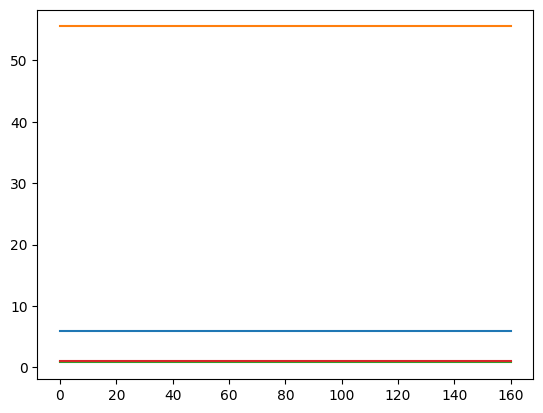

In [ ]:
plt.plot([i[0] for i in factor_hist])
plt.plot([i[1] for i in factor_hist])
plt.plot([i[2] for i in factor_hist])
plt.plot([i[3] for i in factor_hist])
plt.show()

In [82]:
import torch.autograd.functional as F

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(12 * 8 * 8, 1)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        return self.fc(x_flat)


# Create an instance of the model
test_model = SimpleModel()

# Generate some input data (vectorized version)
batch_size = 10
vectorized_input = torch.ones((batch_size, 12, 8, 8), requires_grad=True).view(batch_size, -1)
jacobian_matrix = F.jacobian(lambda x: model(x.view(-1, 12, 8, 8)).sum(), vectorized_input)
jacobian = jacobian_matrix.view(batch_size, 12, 8, 8)

print("Jacobian shape:", jacobian.shape)


torch.Size([10, 768])
tensor(-14.8880, grad_fn=<SumBackward0>)
Jacobian shape: torch.Size([10, 12, 8, 8])


In [63]:
[i for i in test_model.parameters()]

[Parameter containing:
 tensor([[-0.2408, -0.2951, -0.0612, -0.0810]], requires_grad=True),
 Parameter containing:
 tensor([0.4001], requires_grad=True)]